In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods)
    data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
data = run('NQ', bolli_reduced, output=True)

weights: 
bolli_reduced_5      0.186086
bolli_reduced_10     0.163162
bolli_reduced_20     0.154211
bolli_reduced_40     0.154280
bolli_reduced_80     0.162365
bolli_reduced_160    0.179897

adjustments:
bolli_reduced_5      26.296078
bolli_reduced_10     13.934512
bolli_reduced_20      9.770706
bolli_reduced_40      8.030934
bolli_reduced_80      6.821974
bolli_reduced_160     5.496496

multiplier:
1.293587264307515

correlations:
                   bolli_reduced_5  bolli_reduced_10  bolli_reduced_20  \
bolli_reduced_5           1.000000          0.901072          0.729500   
bolli_reduced_10          0.901072          1.000000          0.898484   
bolli_reduced_20          0.729500          0.898484          1.000000   
bolli_reduced_40          0.584421          0.733167          0.897994   
bolli_reduced_80          0.468615          0.600289          0.748910   
bolli_reduced_160         0.377546          0.498715          0.625703   

                   bolli_reduced_40  bolli_re

In [10]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.274637450937814, 6.5152622233360775)

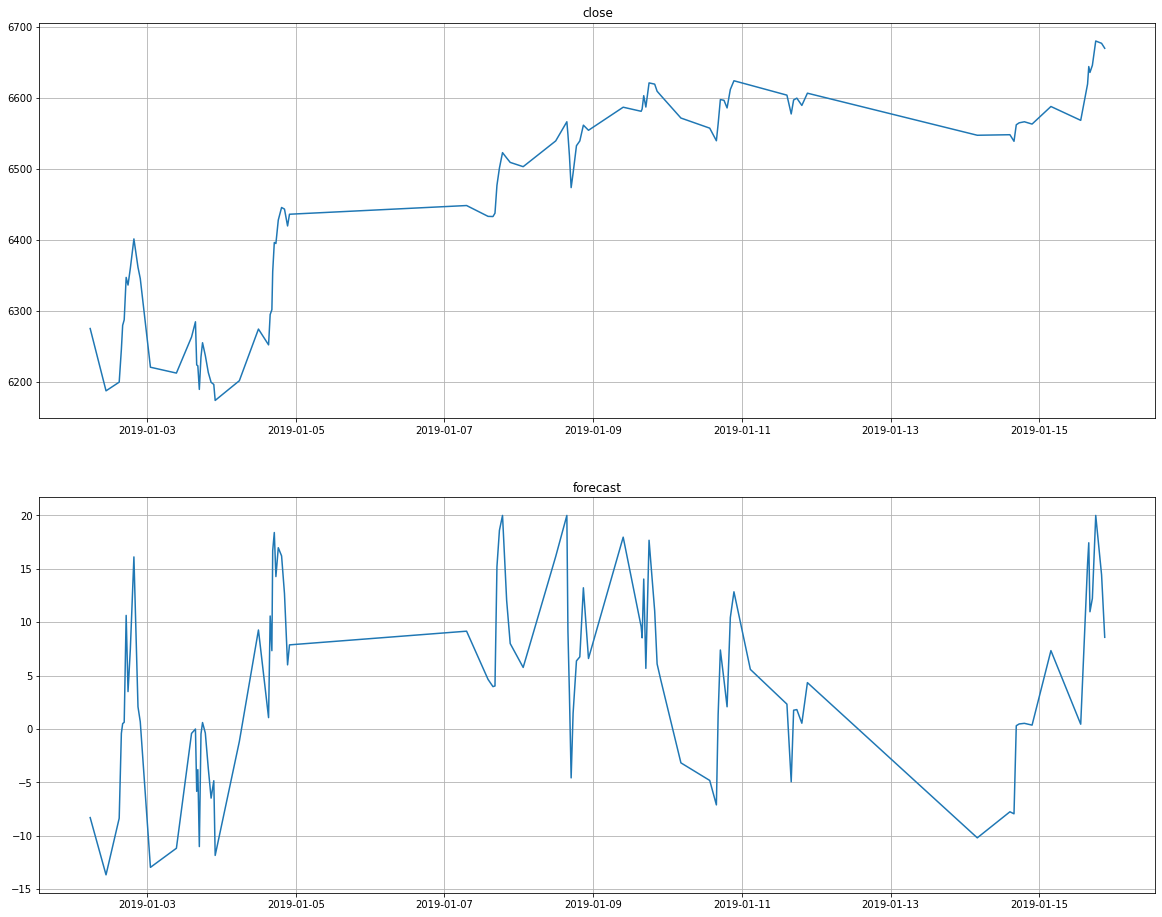

In [11]:
plot(data[['close', 'forecast']].iloc[:100])

In [12]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.0491483,0.00507976,0.11741,0.0677159,0.105111,0.0600603,0.0724087,0.0934868,-0.0020746
Cumulative returns,0.0342736,0.00356524,0.0810944,0.0470966,0.072723,0.0418177,0.050327,0.0647849,-0.00145761
Annual volatility,0.18533,0.169347,0.14205,0.139921,0.132028,0.116188,0.0763182,0.0661572,0.048895
Sharpe ratio,0.351068,0.113866,0.852056,0.537564,0.822476,0.559722,0.954022,1.38402,-0.0181251
Calmar ratio,0.525119,0.0438553,1.45553,0.676325,1.31298,0.96043,2.4807,3.64987,-0.0601154
Stability,0.413953,0.0110849,0.458336,0.275045,0.488561,0.669811,0.71561,0.889515,0.616339
Max drawdown,-0.0935946,-0.11583,-0.0806648,-0.100123,-0.0800558,-0.0625348,-0.0291888,-0.0256138,-0.0345103
Omega ratio,1.05774,1.01882,1.16185,1.10401,1.16834,1.11943,1.24801,1.44441,0.994637
Sortino ratio,0.504155,0.174869,1.38691,0.887598,1.38948,0.882592,1.54268,2.23767,-0.0251582
Skew,-0.0342303,0.433065,0.547569,0.815992,0.848184,0.332165,0.324338,-0.00399176,-0.755074


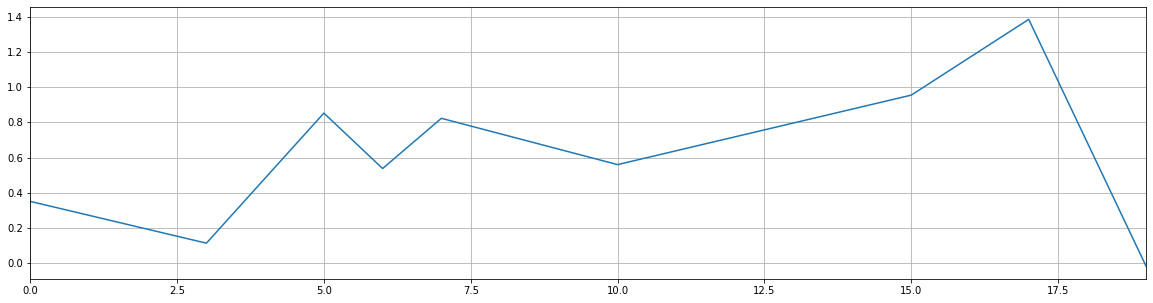

In [13]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [14]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.864777,0.827482,0.785476,0.761564,0.621316,0.494846,0.471128,0.320485
3,0.864777,1.000000,0.927120,0.876292,0.844304,0.692817,0.572085,0.519658,0.364458
5,0.827482,0.927120,1.000000,0.955701,0.917496,0.766859,0.654590,0.593423,0.406895
6,0.785476,0.876292,0.955701,1.000000,0.967021,0.820100,0.705694,0.640147,0.452009
7,0.761564,0.844304,0.917496,0.967021,1.000000,0.851057,0.712531,0.640910,0.460015
10,0.621316,0.692817,0.766859,0.820100,0.851057,1.000000,0.736682,0.656909,0.541817
15,0.494846,0.572085,0.654590,0.705694,0.712531,0.736682,1.000000,0.864620,0.661647
17,0.471128,0.519658,0.593423,0.640147,0.640910,0.656909,0.864620,1.000000,0.804154
19,0.320485,0.364458,0.406895,0.452009,0.460015,0.541817,0.661647,0.804154,1.000000


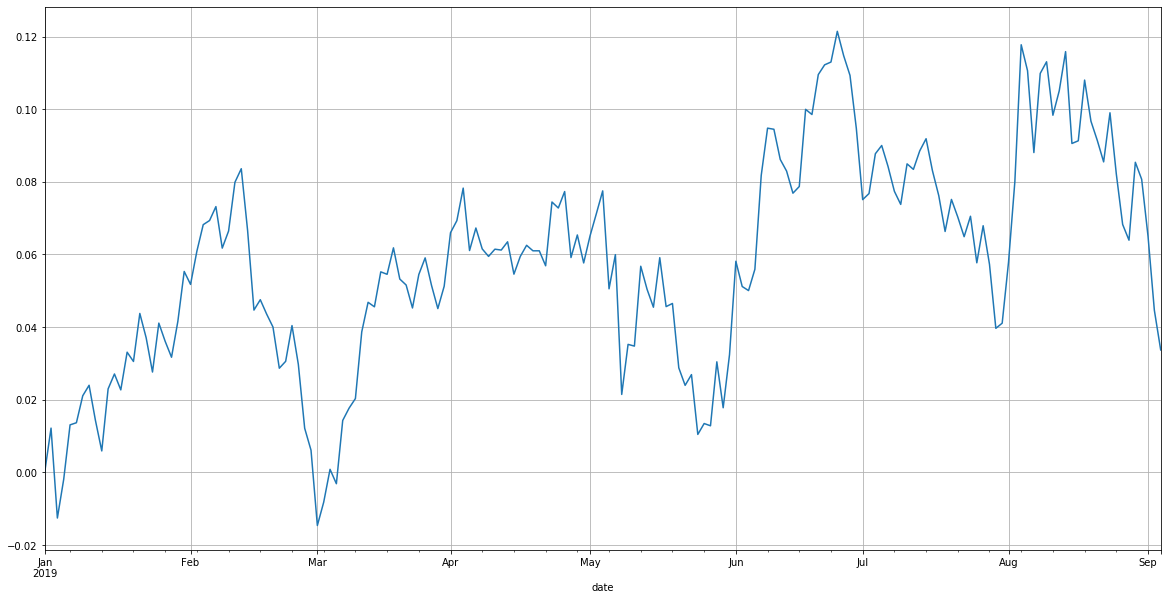

In [15]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

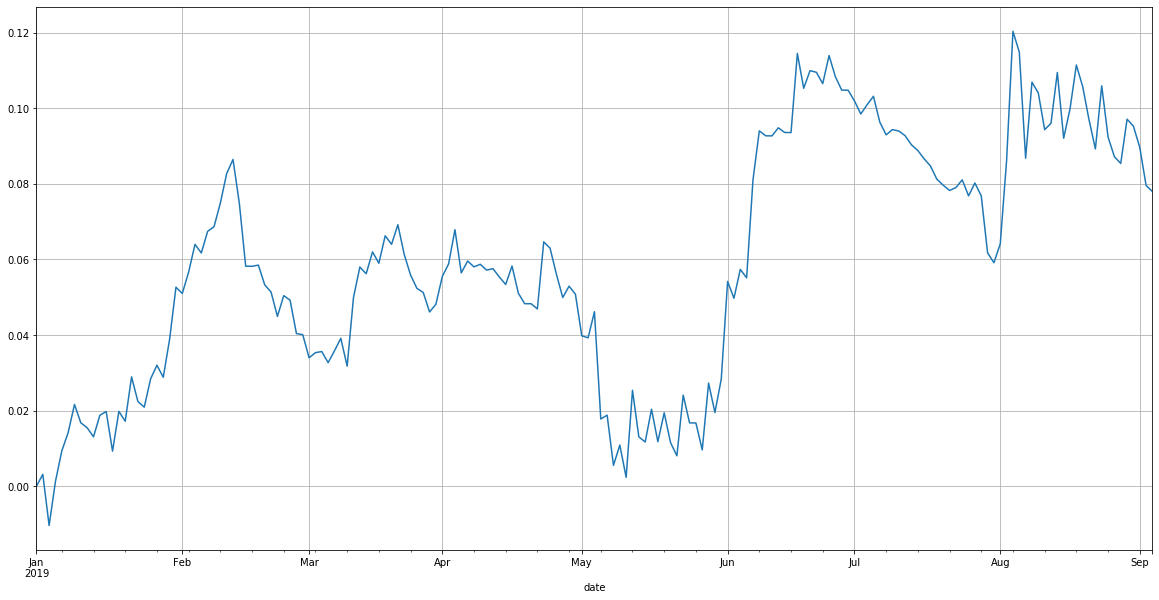

In [16]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

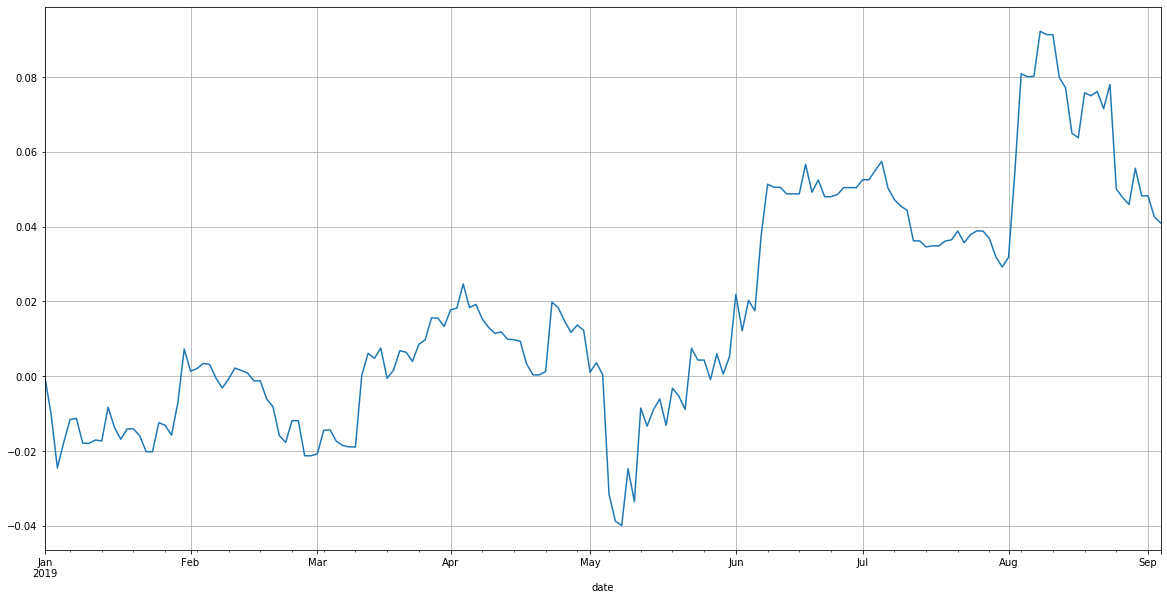

In [17]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);